# Transformers
We're now going to extend the previous work of encoder/decoder architectures to what has become the de-facto way of modelling sequential data: Transformers.

The data loading is more involved this time around, but we'll ignore the details for now. We will ultimately need to see how such work would translate to the AlphaFold case, but let's focus on the model for now:

In [1]:
import re
import os
import random
import pandas as pd
import numpy as np
import urllib.request
import unicodedata
import zipfile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(0)

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

if not os.path.exists("data.zip"):
    url = "https://download.pytorch.org/tutorial/data.zip"
    urllib.request.urlretrieve(url, "data.zip")

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

tensor_pairs = [tensorsFromPair(pair) for pair in pairs]

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elle s en sort tres bien .', 'she s getting on all right .']


In [77]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim, heads):
        super(SelfAttention, self).__init__()
        
        # assume the key, query, and value vector dim are all the same (hidden_dim)
        self.hidden_dim = hidden_dim
        self.heads = heads
        
        self.keys = nn.Linear(hidden_dim, hidden_dim * heads)
        self.queries = nn.Linear(hidden_dim, hidden_dim * heads)
        self.values = nn.Linear(hidden_dim, hidden_dim * heads)
        
        self.unify = nn.Linear(hidden_dim * heads, hidden_dim)
        
    def forward(self, embedded):
        N, T, H = embedded.shape
        
        keys = self.keys(embedded).view(N, T, self.heads, H)
        queries = self.queries(embedded).view(N, T, self.heads, H)
        values = self.values(embedded).view(N, T, self.heads, H)
        
        # folds all the heads together into a single dimension
        keys = keys.transpose(1, 2).view(N * self.heads, T, H)
        queries = queries.transpose(1, 2).view(N * self.heads, T, H)
        values = values.transpose(1, 2).view(N * self.heads, T, H)
        
        keys /= self.hidden_dim ** (1/4)
        queries /= self.hidden_dim ** (1/4)
        
        dot = torch.bmm(queries, keys.transpose(1, 2)) # attention weights (un-norm)
        dot = F.softmax(dot, dim=2) # attention weights (norm)
        
        attended = torch.bmm(dot, values).view(N, T, self.heads, H)
        attended = attended.transpose(1, 2).view(N * self.heads, T, H)
        
        return attended

In [78]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, heads):
        super(TransformerBlock, self).__init__()
        
        self.attention = SelfAttention(hidden_dim, heads)
        self.ff = nn.Sequential(
          nn.Linear(hidden_dim, 4 * hidden_dim),
          nn.ReLU(),
          nn.Linear(4 * hidden_dim, hidden_dim))
        
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
    def forward(self, x):
        attended = self.attention(x)
        x = self.layer_norm1(attended + x)
        
        ff = self.ff(x)
        x = self.layer_norm2(ff + x)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
                
        depth = 4
        
        
    def forward(self, x):
        pass

In [22]:
# --- model params
N = 1
H = 128
input_seq_len = max([tensor_pair[0].shape[0] for tensor_pair in tensor_pairs])

# --- training params
epochs = 100
batch_size = 128
learning_rate = 0.01
teacher_forcing_prob = 0.75

tensor_pairs = np.array(tensor_pairs)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    idx = np.random.choice(np.arange(len(tensor_pairs)), batch_size, replace=False)
    sample = tensor_pairs[idx]
    
    optimizer.zero_grad()
    
    loss = 0
    
    for pair in sample:
        input_sentence = pair[0]
        output_sentence = pair[1]
        
        # context becomes first hidden state of decoder
        hidden_enc = torch.zeros((1, N, H))
        encoded_sentence = torch.zeros((N, input_seq_len, H))

        for idx, word in enumerate(input_sentence):
            hidden_enc = encoder(torch.tensor([[[word]]]), hidden_enc)
            encoded_sentence[:, idx, :] = hidden_enc.squeeze(1)
        
        prev_word = torch.tensor(np.array([[[SOS_token]]]))
        hidden_dec = hidden_enc
        for word in output_sentence:
            predicted_word_probs, hidden_dec = decoder(prev_word, hidden_dec, encoded_sentence)
            
            if random.random() < teacher_forcing_prob:
                prev_word_value = word
            else:
                prev_word_value = torch.argmax(predicted_word_probs)
            prev_word = torch.tensor(np.array([[[prev_word_value]]]))
            
            loss += loss_criterion(predicted_word_probs, word)
            
            if prev_word_value == EOS_token:
                break
    
    loss.backward()
    
    encoder_optim.step()
    decoder_optim.step()
    
    losses.append(loss.detach().numpy())
    
    print(f"Epoch : {epoch}/{epochs} -- Loss : {loss}")

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_17603/134443230.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(attention).unsqueeze(2) # N x H x 1
/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_17603/3007777419.py:53: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prev_word = torch.tensor(np.array([[[prev_word_value]]]))


Epoch : 0/100 -- Loss : 7292.82763671875
Epoch : 1/100 -- Loss : 3734.854248046875
Epoch : 2/100 -- Loss : 7286.24072265625
Epoch : 3/100 -- Loss : 11982.6005859375
Epoch : 4/100 -- Loss : 45385.8046875
Epoch : 5/100 -- Loss : 17481.611328125
Epoch : 6/100 -- Loss : 18833.734375
Epoch : 7/100 -- Loss : 20800.341796875
Epoch : 8/100 -- Loss : 32846.96484375
Epoch : 9/100 -- Loss : 37000.64453125
Epoch : 10/100 -- Loss : 20512.810546875
Epoch : 11/100 -- Loss : 19247.69921875
Epoch : 12/100 -- Loss : 35532.7890625
Epoch : 13/100 -- Loss : 25233.828125
Epoch : 14/100 -- Loss : 34770.34375
Epoch : 15/100 -- Loss : 41711.30078125
Epoch : 16/100 -- Loss : 72371.25
Epoch : 17/100 -- Loss : 46960.9921875
Epoch : 18/100 -- Loss : 39626.10546875
Epoch : 19/100 -- Loss : 49608.6015625
Epoch : 20/100 -- Loss : 67348.8359375
Epoch : 21/100 -- Loss : 47755.85546875
Epoch : 22/100 -- Loss : 58677.62109375
Epoch : 23/100 -- Loss : 41885.40234375
Epoch : 24/100 -- Loss : 51562.5546875
Epoch : 25/100 --

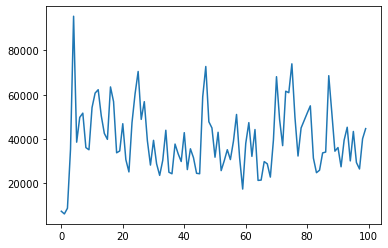

In [9]:
plt.plot(range(len(losses)), losses)
plt.show()

In [18]:
pair = random.choice(tensor_pairs) # 10, 15 : i'm
input_sentence = pair[0]
output_sentence = pair[1]
    
hidden_enc = torch.zeros((1, N, H))
encoded_sentence = torch.zeros((N, input_seq_len, H))

for idx, word in enumerate(input_sentence):
    hidden_enc = encoder(torch.tensor([[[word]]]), hidden_enc)
    encoded_sentence[:, idx, :] = hidden_enc.squeeze(1)
        
prev_word = torch.tensor(np.array([[[SOS_token]]]))
hidden_dec = hidden_enc

input_sentence_words = [input_lang.index2word[int(word_idx.numpy())] for word_idx in input_sentence]
output_sentence_words = [output_lang.index2word[int(word_idx.numpy())] for word_idx in output_sentence]
predicted_output_sentence = []

prev_word_value = None

for word in output_sentence_words:
    predicted_word_probs, hidden_dec = decoder(prev_word, hidden_dec, encoded_sentence)
    prev_word_value = torch.argmax(predicted_word_probs)
    prev_word = torch.tensor(np.array([[[prev_word_value]]]))
    predicted_output_sentence.append(output_lang.index2word[int(prev_word_value.numpy())])
    
print(input_sentence_words)
print(output_sentence_words)
print(predicted_output_sentence)

['nous', 'ne', 'sommes', 'pas', 'coupables', '.', 'EOS']
['we', 're', 'not', 'guilty', '.', 'EOS']
['we', 'going', 'EOS', 'EOS', 'EOS', 'EOS']


/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_17603/1737403886.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(attention).unsqueeze(2) # N x H x 1
